# Grasp and Lift Data Analysis

Import a bunch of packages that will help us load/preprocess data and build various models.

In [8]:
import mne
import numpy as np
import os
import pandas as pd

from imblearn.over_sampling import SMOTE

from mne import create_info, find_events, Epochs, Evoked, EvokedArray
from mne.channels import read_montage
from mne.decoding import Vectorizer, get_coef, LinearModel, CSP
from mne.epochs import concatenate_epochs
from mne.io import RawArray
from mne.preprocessing import Xdawn

from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [9]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Globals

In [10]:
# Change to false once you are ready to train on the entire dataset. When true,
#  only a small representative sample of the training set will be used.
USE_DEBUG_TRAINING_DATASET = True

# Change to True when you are ready to cache the preprocessed data. This is set
#  to False by default because it is very easy to forget you are using cached data
#  and futile-y change the preprocessing code.
CACHE_ENABLED = False

# Sample frequency of the resampled dataset. The frequency of the dataset
#  when recorded was 500hz. If SFREQ < 500, the dataset will be resampled
#  to SFREQ.
SFREQ = 100

# Paths to the train and test datasets.
TRAIN_DATA_PATH = './data/train'
TEST_DATA_PATH = './data/test'

## Loading Data

Given a filename, load it into a MNE Raw object.

In [11]:
def create_mne_raw_object(fname):
    # Read EEG file
    data = pd.read_csv(fname)

    # Get channel names
    ch_names = list(data.columns[1:])

    # Read EEG standard montage from mne
    montage = read_montage('standard_1005', ch_names)

    # Events file
    ev_fname = fname.replace('_data', '_events')

    # Read event file
    events = pd.read_csv(ev_fname)
    events_names = events.columns[1:]
    events_data = np.array(events[events_names]).T

    # Concatenate event file and data
    data = np.concatenate( (np.array(data[ch_names]).T, events_data) )

    # Define channel type, the first is EEG, the last 6 are stimulations
    ch_type = ['eeg']*len(ch_names) + ['stim']*6

    ch_names.extend(events_names)

    # Create and populate MNE info structure
    info = create_info(ch_names, sfreq=500.0, ch_types=ch_type, montage=montage)

    # Create raw object
    raw = RawArray(data, info, verbose=False)

    return raw

For a particular data path (usually train or test), a range of subjects, and a range of recorded series (check raw data for more information) load the data.

1. For every subject in the given subject range.
2. For every data series from the subject
3. Find the events and build epochs of training data around the event marker. 
4. Concatenate all epochs together.

In [12]:
def unique_rows(a):
    order = np.lexsort(a.T)
    a = a[order]
    diff = np.diff(a, axis=0)
    ui = np.ones(len(a), 'bool')
    ui[1:] = (diff != 0).any(axis=1) 
    return a[ui]

def load_subject_series_epochs(data_path, subject_range, series_range, tmin=-0.2, tmax=0.5, baseline=(None, 0), stim_channel=None):
    all_epochs_list = []

    for subject in subject_range:
        subject_fname = data_path + '/subj{0}'.format(subject)

        for series in series_range:
            subject_series_fname = subject_fname + '_series{0}_data.csv'.format(series)
            subject_series = create_mne_raw_object(subject_series_fname)
            subject_series_events = find_events(subject_series, stim_channel=stim_channel, verbose=False)
            epochs = Epochs(subject_series, subject_series_events, tmin=tmin, tmax=tmax, baseline=baseline, verbose=False)
            all_epochs_list.append(epochs)
            
    all_epochs = concatenate_epochs(all_epochs_list)
    return all_epochs

def load_subject_series_data(data_path, subject_range, series_range):
    data = None

    for subject in subject_range:
        subject_fname = data_path + '/subj{0}'.format(subject)

        for series in series_range:
            subject_series_fname = subject_fname + '_series{0}_data.csv'.format(series)
            subject_series = create_mne_raw_object(subject_series_fname)

            if data:
                data.append(subject_series)
            else:
                data = subject_series

    return data

## Exploratory Analysis

Load all train and test data.

Load train and test data epochs for every stim channel:
1. HandStart
2. FirstDigitTouch
3. BothStartLoadPhase
4. LiftOff
5. Replace
6. BothReleased

In [13]:
train_subject_range = range(1, 12) if not USE_DEBUG_TRAINING_DATASET else range(1, 2)
train_series_range = range(1, 9)

test_subject_range = range(12, 13)
test_series_range = range(1, 9)

print("TRAIN SUBJECT RANGE: {0}".format(train_subject_range))

TRAIN SUBJECT RANGE: [1]


In [14]:
# BothReleased
both_released_train_data_epochs = load_subject_series_epochs(data_path=TRAIN_DATA_PATH,
                                                             subject_range=train_subject_range,
                                                             series_range=train_series_range,
                                                             stim_channel='BothReleased')
both_released_test_data_epochs = load_subject_series_epochs(data_path=TRAIN_DATA_PATH,
                                                            subject_range=test_subject_range,
                                                            series_range=test_series_range,
                                                            stim_channel='BothReleased')

260 matching events found
Applying baseline correction (mode: mean)
260 matching events found
Applying baseline correction (mode: mean)


In [15]:
# Replace
replace_train_data_epochs = load_subject_series_epochs(data_path=TRAIN_DATA_PATH,
                                                       subject_range=train_subject_range,
                                                       series_range=train_series_range,
                                                       stim_channel='Replace')
replace_test_data_epochs = load_subject_series_epochs(data_path=TRAIN_DATA_PATH,
                                                      subject_range=test_subject_range,
                                                      series_range=test_series_range,
                                                      stim_channel='Replace')

260 matching events found
Applying baseline correction (mode: mean)
260 matching events found
Applying baseline correction (mode: mean)


In [16]:
# LiftOff
liftoff_train_data_epochs = load_subject_series_epochs(data_path=TRAIN_DATA_PATH,
                                                       subject_range=train_subject_range,
                                                       series_range=train_series_range,
                                                       stim_channel='LiftOff')
liftoff_test_data_epochs = load_subject_series_epochs(data_path=TRAIN_DATA_PATH,
                                                      subject_range=test_subject_range,
                                                      series_range=test_series_range,
                                                      stim_channel='LiftOff')

260 matching events found
Applying baseline correction (mode: mean)
260 matching events found
Applying baseline correction (mode: mean)


In [17]:
# BothStartLoadPhase
both_start_load_phase_train_data_epochs = load_subject_series_epochs(data_path=TRAIN_DATA_PATH,
                                                                     subject_range=train_subject_range,
                                                                     series_range=train_series_range,
                                                                     stim_channel='BothStartLoadPh')
both_start_load_phase_test_data_epochs = load_subject_series_epochs(data_path=TRAIN_DATA_PATH,
                                                                       subject_range=test_subject_range,
                                                                       series_range=test_series_range,
                                                                       stim_channel='BothStartLoadPh')

260 matching events found
Applying baseline correction (mode: mean)
260 matching events found
Applying baseline correction (mode: mean)


In [18]:
# FirstDigitTouch
first_digit_touch_train_data_epochs = load_subject_series_epochs(data_path=TRAIN_DATA_PATH,
                                                                 subject_range=train_subject_range,
                                                                 series_range=train_series_range,
                                                                 stim_channel='FirstDigitTouch')
first_digit_touch_test_data_epochs = load_subject_series_epochs(data_path=TRAIN_DATA_PATH,
                                                                   subject_range=test_subject_range,
                                                                   series_range=test_series_range,
                                                                   stim_channel='FirstDigitTouch')

260 matching events found
Applying baseline correction (mode: mean)
260 matching events found
Applying baseline correction (mode: mean)


In [19]:
# HandStart
hand_start_train_data_epochs = load_subject_series_epochs(data_path=TRAIN_DATA_PATH,
                                                          subject_range=train_subject_range,
                                                          series_range=train_series_range,
                                                          stim_channel='HandStart')
hand_start_test_data_epochs = load_subject_series_epochs(data_path=TRAIN_DATA_PATH,
                                                         subject_range=test_subject_range,
                                                         series_range=test_series_range,
                                                         stim_channel='HandStart')

260 matching events found
Applying baseline correction (mode: mean)
260 matching events found
Applying baseline correction (mode: mean)


### 'HandStart' Case Study

#### Evoked Response Visualization

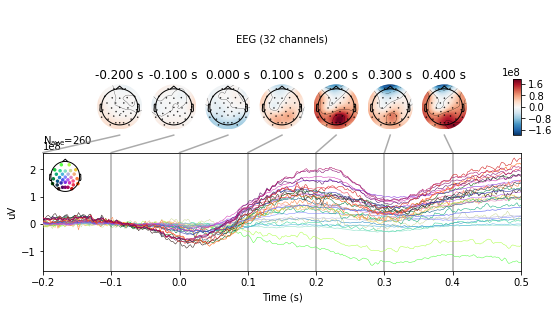

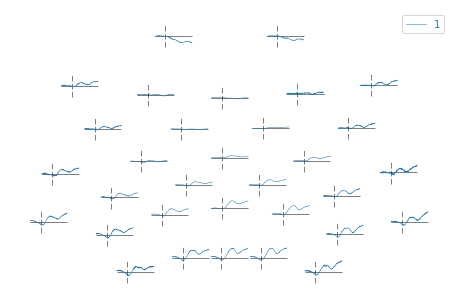

In [20]:
hand_start_train_data_evoked = hand_start_train_data_epochs.average()

# hand_start_train_data_evoked.plot()
# hand_start_train_data_evoked.plot_image()
hand_start_train_data_evoked.plot_joint(times=[-0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4])
hand_start_train_data_evoked.plot_topo()
plt.close()

Downsample data and view joint plot again to observe the distortion to the signal.

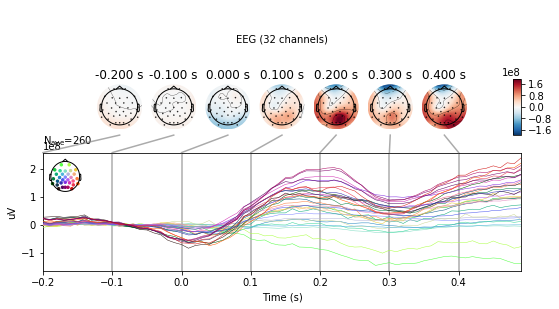

In [21]:
downsampled_hand_start_train_data = hand_start_train_data_epochs.copy().resample(SFREQ, npad='auto')
downsampled_hand_start_train_data_evoked = downsampled_hand_start_train_data.average()
downsampled_hand_start_train_data_evoked.plot_joint(times=[-0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4])
plt.close()

Filter frequency bands and view joint plot again to observe the distortion to the signal.

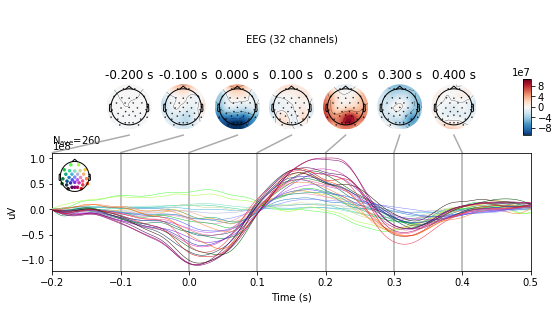

In [22]:
filtered_hand_start_train_data = hand_start_train_data_epochs.copy().pick_types(eeg=True).filter(1, 20,
                                                                                                 method='iir',
                                                                                                 n_jobs=-1,
                                                                                                 verbose=False)
filtered_hand_start_train_data_evoked = filtered_hand_start_train_data.average()
filtered_hand_start_train_data_evoked.plot_joint(times=[-0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4])
plt.close()

Downsample data already filtered by frequency band and view joint plot again to observe the distortion of the signal.

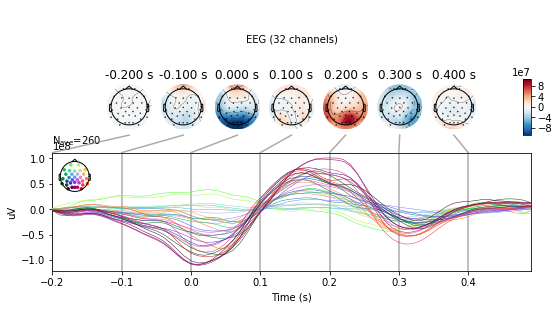

In [23]:
downsampled_filtered_hand_start_train_data = filtered_hand_start_train_data.copy().resample(SFREQ, npad='auto')
downsampled_filtered_hand_start_train_data_evoked = downsampled_filtered_hand_start_train_data.average()
downsampled_filtered_hand_start_train_data_evoked.plot_joint(times=[-0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4])
plt.close()

#### xDAWN Denoising Algorithm

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Transforming to Xdawn space
Zeroing out 30 Xdawn components
Inverse transforming to sensor space


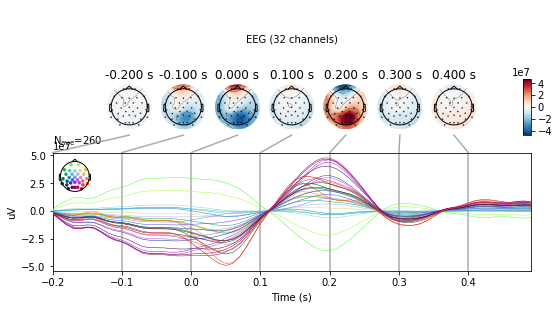

In [24]:
# Fit xdawn
xd = Xdawn(n_components=2)
xd.fit(hand_start_train_data_epochs)
denoised_downsampled_filtered_hand_start_train_data = xd.apply(downsampled_filtered_hand_start_train_data)['1']

# Plot evoked response after Xdawn
denoised_downsampled_filtered_hand_start_train_data.average().plot_joint(times=[-0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4])
plt.close()

#### Common Spatial Patterns Before/After 'HandStart' 

In [25]:
before_event_epochs = load_subject_series_epochs(data_path=TRAIN_DATA_PATH,
                                                 subject_range=train_subject_range,
                                                 series_range=train_series_range,
                                                 stim_channel='HandStart',
                                                 tmin=-2,
                                                 tmax=-0.5,
                                                 baseline=None)
after_event_epochs = load_subject_series_epochs(data_path=TRAIN_DATA_PATH,
                                                 subject_range=train_subject_range,
                                                 series_range=train_series_range,
                                                 stim_channel='HandStart',
                                                 tmin=0.5,
                                                 tmax=2,
                                                 baseline=None)

260 matching events found
No baseline correction applied
260 matching events found
No baseline correction applied


In [26]:
before_event_epochs._set_times(after_event_epochs.times)

before_event_epochs.filter(7, 35, method='iir', n_jobs=-1, verbose=False)
after_event_epochs.filter(7, 35, method='iir', n_jobs=-1, verbose=False)

<Epochs  |   260 events (all good), 0.5 - 2 sec, baseline off, ~56.7 MB, data loaded,
 '1': 260>

In [27]:
x = concatenate_epochs([before_event_epochs, after_event_epochs]).get_data()
y = np.ones(x.shape[0])
y[:len(before_event_epochs)] *= 0

520 matching events found
No baseline correction applied


In [28]:
csp = CSP(reg='pca')
csp.fit_transform(x, y)

Estimating covariance using PCA
... rank: 5 - loglik: -1230.784
... rank: 10 - loglik: -1224.343


LinAlgError: unrecoverable internal error.

In [ ]:
csp.plot_filters(before_event_epochs.info)
csp.plot_patterns(before_event_epochs.info)
plt.close()

## Model Analysis

### Prepare Data

In [8]:
# Load all data
all_train_data = load_subject_series_data(data_path=TRAIN_DATA_PATH,
                                          subject_range=train_subject_range,
                                          series_range=train_series_range)
all_test_data = load_subject_series_data(data_path=TRAIN_DATA_PATH,
                                         subject_range=test_subject_range,
                                         series_range=test_series_range)

In [9]:
# Downsample train and test data.
all_train_data = all_train_data.resample(SFREQ, npad='auto')
all_test_data = all_test_data.resample(SFREQ, npad='auto')

In [10]:
# Split train data into data and labels
x_train = all_train_data.copy().pick_types(eeg=True).filter(1, 20,
                                                            method='iir',
                                                            n_jobs=-1,
                                                            verbose=False).to_data_frame().values
y_train = all_train_data.copy().pick_types(stim=True).to_data_frame().values
y_train = y_train > 0

# Split test data into data and labels
x_test = all_test_data.copy().pick_types(eeg=True).filter(1, 20,
                                                          method='iir',
                                                          n_jobs=-1,
                                                          verbose=False).to_data_frame().values
y_test = all_test_data.copy().pick_types(stim=True).to_data_frame().values
y_test = y_test > 0

print("\nDATA SHAPE: {0}".format(x_train.shape))
print("LABEL SHAPE: {0}".format(y_train.shape))
print("\nSAMPLE DATA POINT: {0}".format(x_train[5]))

# Discard references to original data for memory performance
all_train_data = None
all_test_data = None

Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...

DATA SHAPE: (3275564, 32)
LABEL SHAPE: (3275564, 6)

SAMPLE DATA POINT: [  2.75595454e+08   1.23630700e+08   2.58105933e+08   1.16914477e+08
   7.85385107e+07   1.46526248e+08   2.92073882e+07   1.42237364e+08
   4.40509059e+07  -4.37258522e+06   4.39307122e+07   9.24050056e+07
   1.60945752e+07  -4.49325265e+07  -7.09996534e+06  -5.46273017e+06
   7.30777825e+07   8.32090954e+06  -5.74880172e+06  -2.48251130e+07
  -4.92176455e+07  -5.64029776e+07   5.00407948e+07   8.12183201e+06
  -1.94509200e+07  -3.49208337e+07  -5.90207637e+07   3.14884458e+07
   2.61504781e+07   2.32375395e+07  -4.95582063e+05  -7.82903901e+06]


In [11]:
# Extract 'HandStart' labels
class_type = 'HandStart'
y_train_class_type = y_train[:, 0]
y_test_class_type = y_test[:, 0]

In [12]:
# Apply Xdawn Algorithm
# xd = Xdawn(n_components=2)
# x_train = xd.fit_transform(x_train, y_train_class_type)
# x_test = xd.transform(x_test)

In [13]:
# Normalize data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print("\nSAMPLE DATA POINT: {0}".format(x_train[5]))


SAMPLE DATA POINT: [ 1.49191668  0.69866195  2.70155676  2.05554391  2.13482586  2.69637234
  0.35807891  2.37711531  2.01222643 -0.19152957  0.74371255  1.10095823
  0.31931004 -1.32149407 -0.1389104  -0.06470519  0.73643291  0.11123144
 -0.09941238 -0.41836769 -0.63597267 -0.55771915  0.53013034  0.1007847
 -0.25692333 -0.41800078 -0.58532055  0.29870684  0.25488633  0.22651579
 -0.00471699 -0.07289317]


In [14]:
# Concatenate time points between t_start and t_end
t_start = -0.1
t_end = 0.3

new_x_train = x_train.copy()
new_x_test = x_test.copy()

for t_i in range(int(t_start*SFREQ), int(t_end*SFREQ)+1, 5):
    if t_i == 0:
        continue
    new_x_train = np.hstack((new_x_train, np.roll(x_train, -t_i, axis=0)))
    new_x_test = np.hstack((new_x_test, np.roll(x_test, -t_i, axis=0))) 

x_train = new_x_train
x_test = new_x_test

In [15]:
# Rebalance data
print("% POSITIVE LABELS IN TRAIN SET BEFORE REBALANCE: {0:.2f}%".format(100*np.sum(y_train_class_type)/y_train_class_type.shape[0]))

sm = SMOTE(random_state=12, ratio=1.0, n_jobs=5)
x_train, y_train_class_type = sm.fit_sample(x_train, y_train_class_type)

print("% POSITIVE LABELS IN TRAIN SET AFTER REBALANCE: {0:.2f}%".format(100*np.sum(y_train_class_type)/y_train_class_type.shape[0]))

% POSITIVE LABELS IN TRAIN SET BEFORE REBALANCE: 2.00%
% POSITIVE LABELS IN TRAIN SET AFTER REBALANCE: 50.00%


### Logistic Regression

In [ ]:
# Fit model on class_type labels
model = LogisticRegression()
model.fit(x_train, y_train_class_type)

In [ ]:
# Make predictions on both train, train (rebalanced), and test set
y_train_class_type_pred = model.predict(x_train)
y_test_class_type_pred = model.predict(x_test)

In [ ]:
print("\n============= [TRAIN METRICS] =============\n")
print(classification_report(y_train_class_type, y_train_class_type_pred))

print("\n============= [TEST METRICS] =============\n")
print(classification_report(y_test_class_type, y_test_class_type_pred))

### Multilayer Perceptron

In [16]:
# Fit model on class_type labels
model = MLPClassifier(hidden_layer_sizes=(100,), verbose=True)
model.fit(x_train, y_train_class_type)

Iteration 1, loss = 0.36448123
Iteration 2, loss = 0.29637100
Iteration 3, loss = 0.27417902
Iteration 4, loss = 0.26117319
Iteration 5, loss = 0.25227377


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [ ]:
# Make predictions on both train, train (rebalanced), and test set
y_train_class_type_pred = model.predict(x_train)
y_test_class_type_pred = model.predict(x_test)

In [ ]:
print("\n============= [TRAIN METRICS] =============\n")
print(classification_report(y_train_class_type, y_train_class_type_pred))

print("\n============= [TEST METRICS] =============\n")
print(classification_report(y_test_class_type, y_test_class_type_pred))